In [ ]:
import numpy as np
import pandas as pd
import scipy as scp
import sklearn as skl
import bokeh as bk
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as an
import bokeh as bk
import holoviews as hv

from bokeh.models import HoverTool, LinearColorMapper, LogColorMapper, Label
hv.extension('bokeh')
from bokeh.io import show, output_file, push_notebook, curdoc
from bokeh.models import ColumnDataSource, Select, HoverTool, Panel, Tabs
from bokeh.plotting import figure
from bokeh.models.widgets import MultiSelect, CheckboxGroup, Dropdown
from bokeh.layouts import column , row
from bokeh.themes import Theme

import panel as pn
import panel
import param

In [ ]:
import numpy as np
import seaborn as sns
import pandas as pd
import scipy as scp
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [ ]:
# General options
sns.set_style("ticks")
sns.despine()
N = 30
color_A, color_B = '#CC503E', '#1D6996'
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

# II Inflating degrees of freedom

In [ ]:
for seed in range(10000):
    np.random.seed(seed)
    A = np.random.normal(0.5, 1, 20)
    A2 = np.concatenate((A, A))
    At, Ap = scp.stats.ttest_1samp(A, 0)
    At2, Ap2 = scp.stats.ttest_1samp(A2, 0)
    
    if Ap > 0.1 and Ap2 < 0.03:
        break
        
print(seed, Ap, Ap2)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

sns.scatterplot([0 + np.random.normal(0, 0.02) for _ in range(20)], A, color=color_A)
sns.scatterplot([0.52 + np.random.normal(0, 0.03) for _ in range(40)], A2, color=color_B)

sns.lineplot([-0.1, 0.1], [0, 0], color="#909090")
sns.lineplot([0.4, 0.6], [0, 0], color="#909090")
ax.set_xlim([-0.2, 0.9])

ax.plot([-0.08, -0.08], [A.mean() - A.std(), A.mean() + A.std()], color=color_A)
ax.scatter([-0.08], [A.mean()], color=color_A)

ax.plot([0.42, 0.42], [A2.mean() - A2.std(), A2.mean() + A2.std()], color=color_B)
ax.scatter([0.42], [A2.mean()], color=color_B)


ax.text(0.1, 1.8,  "p: {:.3f}".format(Ap) + "\nt$_{%s}$: %.3f" %(20-1, At), 
        fontsize=14, color=color_A)
ax.text(0.1, 1.2,  "p: {:.3f}".format(Ap2) + "\nt$_{%s}$: %.3f" %(40-1, At2), 
        fontsize=14, color=color_B)

ax.text(0.09, -1.1,'$\overline{\mu}_X, \mu_X$'+': {:.2f}, 0.5'.format(A.mean()), fontsize=12, color="#909090")
ax.text(0.09, -1.4,'$\overline{\sigma}_X, \sigma_X$'+': {:.2f}, 1'.format(A.std()), fontsize=12, color="#909090")

sns.despine(top=True, bottom=True)
plt.tick_params(top='off', bottom='off',  right='off', labelleft='on', labelbottom='off')

plt.savefig('../web/figs/II-pvalues-20VS40.svg', dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
N_list, p0_list, p05_list, p1_list = [], [], [], []

for seed in range(1000):
    for N in range(5, 100):
        t, p0 = scp.stats.ttest_1samp(np.random.normal(0, 1, N), 0)
        t, p05 = scp.stats.ttest_1samp(np.random.normal(0.5, 1, N), 0)
        t, p1 = scp.stats.ttest_1samp(np.random.normal(1, 1, N), 0)
        N_list.append(N)
        p0_list.append(p0)
        p05_list.append(p05)
        p1_list.append(p1)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

sns.lineplot(x="N samples", y="p-value", data=pd.DataFrame({'N samples':N_list, 'p-value':p0_list}), color="#909090")
sns.lineplot(x="N samples", y="p-value", data=pd.DataFrame({'N samples':N_list, 'p-value':p05_list}), color=color_A)
sns.lineplot(x="N samples", y="p-value", data=pd.DataFrame({'N samples':N_list, 'p-value':p1_list}), color=color_B)

sns.lineplot([0, 100], [0.05, 0.05], color="#909090")
ax.text(83, 0.06, "p: 0.05" , fontsize=14, color="#909090")
ax.text(76, 0.4, "$\mu = 0\;\; \sigma = 1$" , fontsize=14, color="#909090")
ax.text(76, 0.36, "$\mu = 0.5\;\; \sigma = 1$" , fontsize=14, color=color_A)
ax.text(76, 0.32, "$\mu = 1\;\; \sigma = 1$" , fontsize=14, color=color_B)
ax.text(76, 0.20, "$H_1: \mu > 0$" , fontsize=14, color="#909090")

sns.despine()
plt.savefig('../web/figs/II-pvalues-N.svg', dpi=300, bbox_inches='tight', transparent=True)

# III - Interpret comparisons between groups without comparing them

In [ ]:
from __future__ import division
import numpy as np
from numpy import random
from scipy.spatial.distance import pdist, cdist
from scipy.stats import kstwobign, pearsonr
from scipy.stats import genextreme

def ks2d2s(x1, y1, x2, y2, nboot=None, extra=False):
    '''Two-dimensional Kolmogorov-Smirnov test on two samples. 
    Parameters
    ----------
    x1, y1 : ndarray, shape (n1, )
        Data of sample 1.
    x2, y2 : ndarray, shape (n2, )
        Data of sample 2. Size of two samples can be different.
    extra: bool, optional
        If True, KS statistic is also returned. Default is False.
    Returns
    -------
    p : float
        Two-tailed p-value.
    D : float, optional
        KS statistic. Returned if keyword `extra` is True.
    Notes
    -----
    This is the two-sided K-S test. Small p-values means that the two samples are significantly different. Note that the p-value is only an approximation as the analytic distribution is unkonwn. The approximation is accurate enough when N > ~20 and p-value < ~0.20 or so. When p-value > 0.20, the value may not be accurate, but it certainly implies that the two samples are not significantly different. (cf. Press 2007)
    References
    ----------
    Peacock, J.A. 1983, Two-Dimensional Goodness-of-Fit Testing in Astronomy, Monthly Notices of the Royal Astronomical Society, vol. 202, pp. 615-627
    Fasano, G. and Franceschini, A. 1987, A Multidimensional Version of the Kolmogorov-Smirnov Test, Monthly Notices of the Royal Astronomical Society, vol. 225, pp. 155-170
    Press, W.H. et al. 2007, Numerical Recipes, section 14.8
    '''
    assert (len(x1) == len(y1)) and (len(x2) == len(y2))
    n1, n2 = len(x1), len(x2)
    D = avgmaxdist(x1, y1, x2, y2)

    if nboot is None:
        sqen = np.sqrt(n1 * n2 / (n1 + n2))
        r1 = pearsonr(x1, y1)[0]
        r2 = pearsonr(x2, y2)[0]
        r = np.sqrt(1 - 0.5 * (r1**2 + r2**2))
        d = D * sqen / (1 + r * (0.25 - 0.75 / sqen))
        p = kstwobign.sf(d)
    else:
        n = n1 + n2
        x = np.concatenate([x1, x2])
        y = np.concatenate([y1, y2])
        d = np.empty(nboot, 'f')
        for i in range(nboot):
            idx = random.choice(n, n, replace=True)
            ix1, ix2 = idx[:n1], idx[n1:]
            #ix1 = random.choice(n, n1, replace=True)
            #ix2 = random.choice(n, n2, replace=True)
            d[i] = avgmaxdist(x[ix1], y[ix1], x[ix2], y[ix2])
        p = np.sum(d > D).astype('f') / nboot
    if extra:
        return p, D
    else:
        return p
    

def avgmaxdist(x1, y1, x2, y2):
    D1 = maxdist(x1, y1, x2, y2)
    D2 = maxdist(x2, y2, x1, y1)
    return (D1 + D2) / 2


def maxdist(x1, y1, x2, y2):
    n1 = len(x1)
    D1 = np.empty((n1, 4))
    for i in range(n1):
        a1, b1, c1, d1 = quadct(x1[i], y1[i], x1, y1)
        a2, b2, c2, d2 = quadct(x1[i], y1[i], x2, y2)
        D1[i] = [a1 - a2, b1 - b2, c1 - c2, d1 - d2]

    # re-assign the point to maximize difference,
    # the discrepancy is significant for N < ~50
    D1[:, 0] -= 1 / n1

    dmin, dmax = -D1.min(), D1.max() + 1 / n1
    return max(dmin, dmax)


def quadct(x, y, xx, yy):
    n = len(xx)
    ix1, ix2 = xx <= x, yy <= y
    a = np.sum(ix1 & ix2) / n
    b = np.sum(ix1 & ~ix2) / n
    c = np.sum(~ix1 & ix2) / n
    d = 1 - a - b - c
    return a, b, c, d


def estat2d(x1, y1, x2, y2, **kwds):
    return estat(np.c_[x1, y1], np.c_[x2, y2], **kwds)


def estat(x, y, nboot=1000, replace=False, method='log', fitting=False):
    '''
    Energy distance statistics test.
    Reference
    ---------
    Aslan, B, Zech, G (2005) Statistical energy as a tool for binning-free
      multivariate goodness-of-fit tests, two-sample comparison and unfolding.
      Nuc Instr and Meth in Phys Res A 537: 626-636
    Szekely, G, Rizzo, M (2014) Energy statistics: A class of statistics
      based on distances. J Stat Planning & Infer 143: 1249-1272
    Brian Lau, multdist, https://github.com/brian-lau/multdist
    '''
    n, N = len(x), len(x) + len(y)
    stack = np.vstack([x, y])
    stack = (stack - stack.mean(0)) / stack.std(0)
    if replace:
        rand = lambda x: random.randint(x, size=x)
    else:
        rand = random.permutation

    en = energy(stack[:n], stack[n:], method)
    en_boot = np.zeros(nboot, 'f')
    for i in range(nboot):
        idx = rand(N)
        en_boot[i] = energy(stack[idx[:n]], stack[idx[n:]], method)

    if fitting:
        param = genextreme.fit(en_boot)
        p = genextreme.sf(en, *param)
        return p, en, param
    else:
        p = (en_boot >= en).sum() / nboot
        return p, en, en_boot


def energy(x, y, method='log'):
    dx, dy, dxy = pdist(x), pdist(y), cdist(x, y)
    n, m = len(x), len(y)
    if method == 'log':
        dx, dy, dxy = np.log(dx), np.log(dy), np.log(dxy)
    elif method == 'gaussian':
        raise NotImplementedError
    elif method == 'linear':
        pass
    else:
        raise ValueError
    z = dxy.sum() / (n * m) - dx.sum() / n**2 - dy.sum() / m**2
    # z = ((n*m)/(n+m)) * z # ref. SR
    return z

In [ ]:
for seed in tqdm(range(1000000)):
    N = 30
    np.random.seed(seed)
    Ax = np.random.uniform(0, 1, N)
    Bx = np.random.uniform(0, 1, N)

    Ay = [i + np.random.normal(0, 0.37) for i in Ax]
    By = [i + np.random.normal(0, 0.37) for i in Bx]
    

    Am, Ab, Ar, Ap, _ = scp.stats.linregress(Ax, Ay)
    Bm, Bb, Br, Bp, _ = scp.stats.linregress(Bx, By)
    
    KS = ks2d2s(Ax, Ay, Bx, By)
    if Ap > 0.08  and  Bp < 0.03 and  Bp > 0.005 and KS > 0.3:
        break
    
print(seed)
print(Ar, Ap)
print(Br, Bp)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

sns.scatterplot(Ax, Ay, color=color_A)
sns.scatterplot(Bx, By, color=color_B)

sns.lineplot([min(Ax), max(Ax)], [Am * min(Ax) + Ab, Am * max(Ax) + Ab], color=color_A)
sns.lineplot([min(Bx), max(Bx)], [Bm * min(Bx) + Bb, Bm * max(Bx) + Bb], color=color_B)
ax.text(0.7, -0.2,'p: {:.3f}, r: {:.2f}'.format(Ap, Ar), fontsize=14, color=color_A)
ax.text(0.7, -0.35,'p: {:.3f}, r: {:.2f}'.format(Bp, Br), fontsize=14, color=color_B)
ax.text(0.7, -0.5,'p$_{KS, 2D}$: ' + '{:.3f}'.format(KS), fontsize=14, color='#909090')
sns.despine()
plt.savefig('../web/figs/III-corrs.svg', dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
for seed in tqdm(range(61000, 1000000)):
    N = 30
    np.random.seed(seed)
    
    A = np.random.normal(1, 10, N)
    B = np.random.normal(6, 7, N)
    
    At, Ap = scp.stats.ttest_1samp(A, 0)
    Bt, Bp = scp.stats.ttest_1samp(B, 0)  
    
    ABt, ABp = scp.stats.ttest_ind(A, B)
    
    if Ap < 0.02 and Bp > 0.08 and ABp > 0.07:
        break
        

    
print(seed)
print(Ap, Bp, ABp)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

sns.scatterplot([0 + np.random.normal(0, 0.02) for _ in range(N)], A, color=color_A)
sns.scatterplot([0.5 + np.random.normal(0, 0.02) for _ in range(N)], B, color=color_B)

sns.lineplot([-0.1, 0.1], [0, 0], color="#909090")
sns.lineplot([0.4, 0.6], [0, 0], color="#909090")
ax.set_xlim([-0.2, 0.9])

ax.plot([-0.08, -0.08], [A.mean() - A.std(), A.mean() + A.std()], color=color_A)
ax.scatter([-0.08], [A.mean()], color=color_A)

ax.plot([0.42, 0.42], [B.mean() - B.std(), B.mean() + B.std()], color=color_B)
ax.scatter([0.42], [B.mean()], color=color_B)


ax.text(0.1, 18,'$\overline{\mu}_A$'+': {:.2f}, '.format(A.mean()), fontsize=12, color=color_A)
ax.text(0.1, 15,'$\overline{\sigma}_A$'+': {:.2f}, '.format(A.std()), fontsize=12, color=color_A)
ax.text(0.6, 18,'$\overline{\mu}_B$'+': {:.2f}, '.format(B.mean()), fontsize=12, color=color_B)
ax.text(0.6, 15,'$\overline{\sigma}_B$'+': {:.2f}, '.format(B.std()), fontsize=12, color=color_B)

ax.text(0.1, -15, "$\overline{\mu}_A > 0$ | " + "p: {:.3f}".format(Ap) + ", t$_{%s}$: %.3f" %(N-1, At), 
        fontsize=10, color=color_A)
ax.text(0.1, -17, "$\overline{\mu}_B > 0$ | " + "p: {:.3f}".format(Bp) + ", t$_{%s}$: %.3f" %(N-1, Bt), 
        fontsize=10, color=color_B)
ax.text(0.1, -19, "$\overline{\mu}_A \\neq \overline{\mu}_B$" + " | p: {:.3f}".format(ABp) + \
        ", t$_{%s}$: %.3f" %(2*N-2, ABt), fontsize=10, color="#909090")
sns.despine(top=True, bottom=True)
plt.tick_params(top='off', bottom='off',  right='off', labelleft='on', labelbottom='off')

plt.savefig('../web/figs/III-ttest.svg', dpi=300, bbox_inches='tight', transparent=True)

# IV - Data is not normal

In [ ]:
# Create datasets with outliers
np.random.seed(10)
A = np.random.normal(0, 1, 15)

O1, O2, O3 = A.copy(), A.copy(), A.copy()
O1[0], O2[0], O3[0] = 2, 5, 7

In [ ]:
fig = plt.figure(figsize=(14, 6))
ax1, ax2, ax3, ax4 = fig.add_subplot(411), fig.add_subplot(412), fig.add_subplot(413), fig.add_subplot(414)

for ax in [ax1, ax2, ax3, ax4]:
    ax.tick_params(top='off', bottom='off',  right='off', left='off', labelleft='off', labelbottom='on')
    sns.despine(top=True, bottom=False, left=True)
    ax.set_xlim([-2, 7.3])
    sns.scatterplot(A[1:], [1] * len(A[1:]), color=color_B, ax=ax)
    
sns.scatterplot([A[0]], [1], color=color_A, ax=ax1)
sns.scatterplot([2], [1], color=color_A, ax=ax2)
sns.scatterplot([5], [1], color=color_A, ax=ax3)
sns.scatterplot([7], [1], color=color_A, ax=ax4)

ax1.plot([A.mean(), A.mean()], [0.5, 1.5], c="#994e95")
ax2.plot([O1.mean(), O1.mean()], [0.5, 1.5], c="#994e95")
ax3.plot([O2.mean(), O2.mean()], [0.5, 1.5], c="#994e95")
ax4.plot([O3.mean(), O3.mean()], [0.5, 1.5], c="#994e95")

ax1.plot([np.median(A), np.median(A)], [0.5, 1.5], c="#38A6A5")
ax2.plot([np.median(O1), np.median(O1)], [0.5, 1.5], c="#38A6A5")
ax3.plot([np.median(O2), np.median(O2)], [0.5, 1.5], c="#38A6A5")
ax4.plot([np.median(O3), np.median(O3)], [0.5, 1.5], c="#38A6A5")

ax1.plot([A.mean() - A.std()/2, A.mean() + A.std()/2], [0.7, 0.7], c="#994e95")
ax2.plot([O1.mean() - O1.std()/2, O1.mean() + O1.std()/2], [0.7, 0.7], c="#994e95")
ax3.plot([O2.mean() - O2.std()/2, O2.mean() + O2.std()/2], [0.7, 0.7], c="#994e95")
ax4.plot([O3.mean() - O3.std()/2, O3.mean() + O3.std()/2], [0.7, 0.7], c="#994e95")

ax1.plot([np.median(A) - scp.stats.median_absolute_deviation(A)/2, 
          np.median(A) + scp.stats.median_absolute_deviation(A)/2], [1.3, 1.3], c="#38A6A5")
ax2.plot([np.median(O1) - scp.stats.median_absolute_deviation(O1)/2, 
          np.median(O1) + scp.stats.median_absolute_deviation(O1)/2], [1.3, 1.3], c="#38A6A5")
ax3.plot([np.median(O2) - scp.stats.median_absolute_deviation(O2)/2, 
          np.median(O2) + scp.stats.median_absolute_deviation(O2)/2], [1.3, 1.3], c="#38A6A5")
ax4.plot([np.median(O3) - scp.stats.median_absolute_deviation(O3)/2, 
          np.median(O3) + scp.stats.median_absolute_deviation(O3)/2], [1.3, 1.3], c="#38A6A5")

plt.tight_layout()

ax1.text(4, 1, '$\mu, \sigma$', color="#994e95", fontsize=20)
ax2.text(4, 1, '$M, MAD$', color="#38A6A5", fontsize=20)

plt.savefig('../web/figs/IV-meanMAD-scatter.svg', dpi=300, bbox_inches='tight', transparent=True)


In [ ]:
fig = plt.figure(figsize=(12, 4))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)

x1 = np.linspace(-3, 3, 100)
x2 = np.linspace(0, 15, 100)
x3 = np.linspace(3, 12, 100)

sns.lineplot(x1, scp.stats.norm(0,1).pdf(x1), color="#909090", ax=ax1)
ax1.title.set_text("N(0,1)")
mean_x1, median_x1 = scp.stats.norm(0,1).mean(), scp.stats.norm(0,1).median()
ax1.plot([mean_x1, mean_x1], [scp.stats.norm(0,1).pdf(mean_x1), 0], color=color_A, alpha=0.8)
ax1.plot([median_x1, median_x1], [scp.stats.norm(0,1).pdf(median_x1), 0], color=color_B, alpha=0.8)


sns.lineplot(x2, scp.stats.chi2(4).pdf(x2), color="#909090", ax=ax2)
ax2.title.set_text("$\chi^2(4)$")
mean_x2, median_x2 = scp.stats.chi2(4).mean(), scp.stats.chi2(4).median()
ax2.plot([mean_x2, mean_x2], [scp.stats.chi2(4).pdf(mean_x2), 0], color=color_A, alpha=0.8)
ax2.plot([median_x2, median_x2], [scp.stats.chi2(4).pdf(median_x2), 0], color=color_B, alpha=0.8)
ax2.text(10, 0.15, '$\mu$', color=color_A, fontsize=20)
ax2.text(10, 0.125, '$M$', color=color_B, fontsize=20)



sns.lineplot(x3, scp.stats.gamma(2,3).pdf(x3), color="#909090", ax=ax3)
ax3.title.set_text("$\Gamma(2,3)$")
mean_x3, median_x3 = scp.stats.gamma(2,3).mean(), scp.stats.gamma(2,3).median()
ax3.plot([mean_x3, mean_x3], [scp.stats.gamma(2,3).pdf(mean_x3), 0], color=color_A, alpha=0.8)
ax3.plot([median_x3, median_x3], [scp.stats.gamma(2,3).pdf(median_x3), 0], color=color_B, alpha=0.8)


sns.despine()
plt.savefig('../web/figs/IV-mean-M-dists.svg', dpi=300, bbox_inches='tight', transparent=True)


# V Low sample numbers

In [ ]:
kahoot_yellow = "#ffa602"
kahoot_green = "#26890c"
kahoot_red = "#ea013a"
kahoot_blue = "#1368ce"

In [ ]:
x1 = np.linspace(-3, 3, 250)

sns.lineplot(x1, scp.stats.norm(0,1).pdf(x1), color=kahoot_red)
sns.lineplot(x1, scp.stats.norm(1,1).pdf(x1), color=kahoot_blue)

sns.lineplot(x1, scp.stats.skewnorm(2).pdf(x1), color=kahoot_yellow)
sns.lineplot(x1, scp.stats.skewnorm(10).pdf(x1), color=kahoot_green)

plt.text(-2, 0.4, 'N(1,1)', color=kahoot_blue, fontsize=20)
plt.text(-2, 0.5, 'N(0,1)', color=kahoot_red, fontsize=20)
plt.text(-2, 0.6, 'N$_S$(2)', color=kahoot_yellow, fontsize=20)
plt.text(-2, 0.7, 'N$_S$(10)', color=kahoot_green, fontsize=20)


sns.despine()
plt.savefig('../web/figs/V-nonnormal-dists.svg', dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
for seed in tqdm(range(10000)): #seed is 4327
    n = 15
    np.random.seed(seed)
    N, S1, S2 = scp.stats.norm(0,1), scp.stats.skewnorm(2), scp.stats.skewnorm(10)
    Nrvs, S1rvs, S2rvs = N.rvs(n), S1.rvs(n), S2.rvs(n)
    
    if np.mean(S1rvs) < 0.45 and np.mean(Nrvs) > 0.7:
        break
        

fig = plt.figure(figsize=(9, 3))
ax1, ax2, ax3 = fig.add_subplot(311), fig.add_subplot(312), fig.add_subplot(313)

for ax in [ax1, ax2, ax3]:
    ax.tick_params(top='off', bottom='off',  right='off', left='off', labelleft='off', labelbottom='on')
    sns.despine(top=True, bottom=False, left=True)
    ax.set_xlim([-2, 4])
    
sns.scatterplot(Nrvs, [1]*n, color='#909090', ax=ax1)
sns.scatterplot(S1rvs, [1]*n, color='#909090', ax=ax2)
sns.scatterplot(S2rvs, [1]*n, color='#909090', ax=ax3)

plt.tight_layout()

plt.savefig('../web/figs/V-nonnormal-gray.svg', dpi=300, bbox_inches='tight', transparent=True)

sns.scatterplot(Nrvs, [1]*n, color=kahoot_red, ax=ax1)
sns.scatterplot(S1rvs, [1]*n, color='#909090', ax=ax2)
sns.scatterplot(S2rvs, [1]*n, color='#909090', ax=ax3)

plt.tight_layout()

plt.savefig('../web/figs/V-nonnormal-color1.svg', dpi=300, bbox_inches='tight', transparent=True)

sns.scatterplot(Nrvs, [1]*n, color=kahoot_red, ax=ax1)
sns.scatterplot(S1rvs, [1]*n, color=kahoot_yellow, ax=ax2)
sns.scatterplot(S2rvs, [1]*n, color="#909090", ax=ax3)

plt.tight_layout()

plt.savefig('../web/figs/V-nonnormal-color2.svg', dpi=300, bbox_inches='tight', transparent=True)

sns.scatterplot(Nrvs, [1]*n, color=kahoot_red, ax=ax1)
sns.scatterplot(S1rvs, [1]*n, color=kahoot_yellow, ax=ax2)
sns.scatterplot(S2rvs, [1]*n, color=kahoot_green, ax=ax3)

plt.tight_layout()

plt.savefig('../web/figs/V-nonnormal-color3.svg', dpi=300, bbox_inches='tight', transparent=True)


In [ ]:
Nsamples_list, N_list, S1_list, S2_list = [], [], [], []

for seed in tqdm(range(500)):
    for n in range(3, 100):
        np.random.seed(seed)
        Nx, S1x, S2x = N.rvs(n), S1.rvs(n), S2.rvs(n)
        
        t, pN = scp.stats.shapiro(Nx)
        t, pS1 = scp.stats.shapiro(S1x)
        t, pS2 = scp.stats.shapiro(S2x)
        Nsamples_list.append(n)
        N_list.append(pN)
        S1_list.append(pS1)
        S2_list.append(pS2)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)

sns.lineplot(x="N samples", y="p-value", data=pd.DataFrame({'N samples':Nsamples_list, 'p-value':N_list}), color="#909090")
sns.lineplot(x="N samples", y="p-value", data=pd.DataFrame({'N samples':Nsamples_list, 'p-value':S1_list}), color=color_A)
sns.lineplot(x="N samples", y="p-value", data=pd.DataFrame({'N samples':Nsamples_list, 'p-value':S2_list}), color=color_B)

sns.lineplot([0, 100], [0.05, 0.05], color="#909090")
ax.text(83, 0.06, "p: 0.05" , fontsize=14, color="#909090")
ax.text(76, 0.36, "N$_S$(2)" , fontsize=14, color=color_A)
ax.text(76, 0.32, "N$_S$(10)" , fontsize=14, color=color_B)
ax.text(76, 0.4, "N(0,1)" , fontsize=14, color="#909090")

sns.despine()
plt.savefig('../web/figs/V-shapiro-N.svg', dpi=300, bbox_inches='tight', transparent=True)

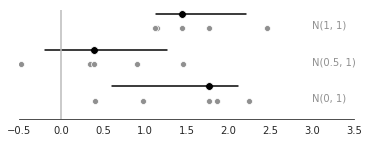

In [27]:
fig = plt.figure(figsize=(6,2))
ax = fig.add_subplot(111)
ax.tick_params(top='off', bottom='off',  right='off', left='off', labelleft='off', labelbottom='on')
sns.despine(top=True, bottom=False, left=True)

def walsh_per(arr, n=10):
    l = []
    for i in range(len(arr)):
        for j in range(len(arr)):
            if i >= j:
                l.append((arr[i] + arr[j])/2)
    l = sorted(l)
    return np.percentile(l, n), np.percentile(l, 100 - n), np.median(arr)

np.random.seed(0)
N0, N1, N2 = scp.stats.norm(0,1).rvs(5), scp.stats.norm(0.5,1).rvs(5), scp.stats.norm(1,1).rvs(5)
low0, hi0, med0 = walsh_per(N0, n=5)
low1, hi1, med1 = walsh_per(N1, n=5)
low2, hi2, med2 = walsh_per(N2, n=5)

sns.scatterplot(N0, [1] * len(N0), color="#909090")
sns.scatterplot([med0], [1.4], color='black', s=60)
ax.plot([low0, hi0], [1.4, 1.4], color='black')

sns.scatterplot(N1, [2] * len(N1), color="#909090")
sns.scatterplot([med1], [2.4], color='black', s=60)
ax.plot([low1, hi1], [2.4, 2.4], color='black')

sns.scatterplot(N2, [3] * len(N2), color="#909090")
sns.scatterplot([med2], [3.4], color='black', s=60)
ax.plot([low2, hi2], [3.4, 3.4], color='black')

ax.plot([0, 0], [0, 4], color="#bbbbbb")

ax.set_ylim([0.5, 3.5])
ax.set_xlim([-0.5, 3.5])

plt.text(3, 1, "N(0, 1)", color="#909090")
plt.text(3, 2, "N(0.5, 1)", color="#909090")
plt.text(3, 3, "N(1, 1)", color="#909090")


plt.savefig('../web/figs/V-walsh.svg', dpi=300, bbox_inches='tight', transparent=True)

# VI - Spurious correlations 

In [ ]:
N = 20

for seed in tqdm(range(1000, 10000)):
    np.random.seed(seed)
    n = np.random.normal(0, 1, (N, 2))
    
    out1 = [1.5,1.5]
    out2 = [3,3]
    out3 = [6, 6]

    m1, b1, r1, p1, _ = scp.stats.linregress(n[:,0].tolist() + [out1[0]], n[:,1].tolist() + [out1[1]])
    m2, b2, r2, p2, _ = scp.stats.linregress(n[:,0].tolist() + [out2[0]], n[:,1].tolist() + [out2[1]])
    m3, b3, r3, p3, _ = scp.stats.linregress(n[:,0].tolist() + [out3[0]], n[:,1].tolist() + [out3[1]])

    spm_1 = scp.stats.spearmanr(n[:,0].tolist() + [out1[0]], n[:,1].tolist() + [out1[1]])
    spm_2 = scp.stats.spearmanr(n[:,0].tolist() + [out2[0]], n[:,1].tolist() + [out2[1]])
    spm_3 = scp.stats.spearmanr(n[:,0].tolist() + [out3[0]], n[:,1].tolist() + [out3[1]])
    if p1 > 0.1 and p2 > 0.03 and p2 < 0.08 and p3 < 0.01 and p3 > 0.001:
        break

print(p1, p2, p3)

In [ ]:
fig = plt.figure(figsize=(9,3))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
sns.scatterplot(n[:,0], n[:,1], ax=ax1, color=color_B)
sns.scatterplot(n[:,0], n[:,1], ax=ax2, color=color_B)
sns.scatterplot(n[:,0], n[:,1], ax=ax3, color=color_B)

sns.scatterplot([out1[0]], [out1[1]], ax=ax1, color=color_A)
sns.scatterplot([out2[0]], [out2[1]], ax=ax2, color=color_A)
sns.scatterplot([out3[0]], [out3[1]], ax=ax3, color=color_A)


x0, y0, xf, yf = -4, -4, 7.5, 7.5
ax1.set_xlim([x0,xf]); ax2.set_xlim([x0,xf]); ax3.set_xlim([x0,xf])
ax1.set_ylim([y0,yf]); ax2.set_ylim([y0,yf]); ax3.set_ylim([y0,yf])

sns.lineplot([x0, xf], [m1*x0 + b1, m1 * xf + b1], ax=ax1, color='#909090')
sns.lineplot([x0, xf], [m2*x0 + b2, m2 * xf + b2], ax=ax2, color='#909090')
sns.lineplot([x0, xf], [m3*x0 + b3, m3 * xf + b3], ax=ax3, color='#909090')

ax1.text(3.5, 5, "r: {:.2f}".format(r1) , fontsize=14, color="#909090")
ax1.text(3.5, 4, "p: {:.3f}".format(p1) , fontsize=14, color="#909090")

ax2.text(3.5, 0, "r: {:.2f}".format(r2) , fontsize=14, color="#909090")
ax2.text(3.5, -1, "p: {:.3f}".format(p2) , fontsize=14, color="#909090")

ax3.text(3.5, 1, "r: {:.2f}".format(r3) , fontsize=14, color="#909090")
ax3.text(3.5, 0, "p: {:.3f}".format(p3) , fontsize=14, color="#909090")


sns.despine()
plt.savefig('../web/figs/VI-correlation-pearson.svg', dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
fig = plt.figure(figsize=(9,3))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
sns.scatterplot(n[:,0], n[:,1], ax=ax1, color=color_B)
sns.scatterplot(n[:,0], n[:,1], ax=ax2, color=color_B)
sns.scatterplot(n[:,0], n[:,1], ax=ax3, color=color_B)

sns.scatterplot([out1[0]], [out1[1]], ax=ax1, color=color_A)
sns.scatterplot([out2[0]], [out2[1]], ax=ax2, color=color_A)
sns.scatterplot([out3[0]], [out3[1]], ax=ax3, color=color_A)


x0, y0, xf, yf = -4, -4, 7.5, 7.5
ax1.set_xlim([x0,xf]); ax2.set_xlim([x0,xf]); ax3.set_xlim([x0,xf])
ax1.set_ylim([y0,yf]); ax2.set_ylim([y0,yf]); ax3.set_ylim([y0,yf])

sns.lineplot([x0, xf], [m1*x0 + b1, m1 * xf + b1], ax=ax1, color='#909090')
sns.lineplot([x0, xf], [m2*x0 + b2, m2 * xf + b2], ax=ax2, color='#909090')
sns.lineplot([x0, xf], [m3*x0 + b3, m3 * xf + b3], ax=ax3, color='#909090')

ax1.text(3.5, 5, "r: {:.2f}".format(spm_1[0]) , fontsize=14, color="#909090")
ax1.text(3.5, 4, "p: {:.3f}".format(spm_1[1]) , fontsize=14, color="#909090")

ax2.text(3.5, 0, "r: {:.2f}".format(spm_2[0]) , fontsize=14, color="#909090")
ax2.text(3.5, -1, "p: {:.3f}".format(spm_2[1]) , fontsize=14, color="#909090")

ax3.text(3.5, 1, "r: {:.2f}".format(spm_3[0]) , fontsize=14, color="#909090")
ax3.text(3.5, 0, "p: {:.3f}".format(spm_3[1]) , fontsize=14, color="#909090")


sns.despine()
plt.savefig('../web/figs/VI-correlation-spearman.svg', dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
N = 20

seed = 10
np.random.seed(seed)
x = np.linspace(0, 10, N)

y_lin = [i + np.random.uniform(0, 2, 1)[0] for i in x]
y_rect = [0 + np.random.uniform(0, 3, 1)[0] if i < 5 else 10 + np.random.uniform(0, 3, 1)[0] for i in x ]


m1, b1, r1, p1, _ = scp.stats.linregress(x, y_lin)
m2, b2, r2, p2, _ = scp.stats.linregress(x, y_rect)

spm_1 = scp.stats.spearmanr(x, y_lin)
spm_2 = scp.stats.spearmanr(x, y_rect)

print(r1, p1, r2, p2)



In [ ]:
fig = plt.figure(figsize=(5, 5 ))
ax1= fig.add_subplot(111)

sns.scatterplot(x, y_lin, ax=ax1, color=color_B)
sns.scatterplot(x, y_rect, ax=ax1, color=color_A)


sns.lineplot([0, 10], [m1*0 + b1, m1 * 10 + b1], ax=ax1, color=color_B)
sns.lineplot([0, 10], [m2*0 + b2, m2 * 10 + b2], ax=ax1, color=color_A)

ax1.text(0, 10, "$r_P$: " + "{:.2f}".format(r1) , fontsize=14, color=color_B)
ax1.text(0, 11, "$p_P$: " + "{:.3f}".format(p1) , fontsize=14, color=color_B)
ax1.text(0, 13, "$r_P$: " + "{:.2f}".format(r2) , fontsize=14, color=color_A)
ax1.text(0, 14, "$p_P$: " + "{:.3f}".format(p2) , fontsize=14, color=color_A)

ax1.text(7, 2, "$r_S$: " + "{:.2f}".format(spm_1[0]) , fontsize=14, color=color_B)
ax1.text(7, 3, "$p_S$: " + "{:.3f}".format(spm_1[1]) , fontsize=14, color=color_B)
ax1.text(7, 4, "$r_S$: " + "{:.2f}".format(spm_2[0]) , fontsize=14, color=color_A)
ax1.text(7, 5, "$p_S$: " + "{:.3f}".format(spm_2[1]) , fontsize=14, color=color_A)

sns.despine()
plt.savefig('../web/figs/VI-correlation-cuadratic.svg', dpi=300, bbox_inches='tight', transparent=True)

In [ ]:
np.random.seed(0)
A = np.random.normal(0, 1, (N,2))

B1 = np.random.normal(0, 1, (N,2))
B2 = np.random.normal(1.2, 1, (N,2))
B3 = np.random.normal(4, 1, (N,2))


m1, b1, r1, p1, _ = scp.stats.linregress(A[:, 0].tolist() + B1[:, 0].tolist(), A[:, 1].tolist() + B1[:, 1].tolist())
m2, b2, r2, p2, _ = scp.stats.linregress(A[:, 0].tolist() + B2[:, 0].tolist(), A[:, 1].tolist() + B2[:, 1].tolist())
m3, b3, r3, p3, _ = scp.stats.linregress(A[:, 0].tolist() + B3[:, 0].tolist(), A[:, 1].tolist() + B3[:, 1].tolist())

In [ ]:
fig = plt.figure(figsize=(9,3))
ax1, ax2, ax3 = fig.add_subplot(131), fig.add_subplot(132), fig.add_subplot(133)
sns.scatterplot(A[:, 0], A[:, 1], ax=ax1, color=color_B)
sns.scatterplot(A[:,0], A[:,1], ax=ax2, color=color_B)
sns.scatterplot(A[:,0], A[:,1], ax=ax3, color=color_B)

sns.scatterplot(B1[:, 0], B1[:, 1], ax=ax1, color=color_A)
sns.scatterplot(B2[:,0], B2[:,1], ax=ax2, color=color_A)
sns.scatterplot(B3[:,0], B3[:,1], ax=ax3, color=color_A)


x0, y0, xf, yf = -3, -3, 7.5, 7.5
ax1.set_xlim([x0,xf]); ax2.set_xlim([x0,xf]); ax3.set_xlim([x0,xf])
ax1.set_ylim([y0,yf]); ax2.set_ylim([y0,yf]); ax3.set_ylim([y0,yf])

sns.lineplot([x0, xf], [m1*x0 + b1, m1 * xf + b1], ax=ax1, color='#909090')
sns.lineplot([x0, xf], [m2*x0 + b2, m2 * xf + b2], ax=ax2, color='#909090')
sns.lineplot([x0, xf], [m3*x0 + b3, m3 * xf + b3], ax=ax3, color='#909090')

ax1.text(3.5, 5, "r: {:.2f}".format(r1) , fontsize=14, color="#909090")
ax1.text(3.5, 4, "p: {:.3f}".format(p1) , fontsize=14, color="#909090")
ax1.text(3, -2, "$\mu_B = \mu_A = 0$", fontsize=10, color="#909090")

ax2.text(3.5, 4, "r: {:.2f}".format(r2) , fontsize=14, color="#909090")
ax2.text(3.5, 5, "p: {:.3f}".format(p2) , fontsize=14, color="#909090")
ax2.text(3, -2, "$\mu_B = 1.2$", fontsize=10, color="#909090")


ax3.text(3.5, 1, "r: {:.2f}".format(r3) , fontsize=14, color="#909090")
ax3.text(3.5, 0, "p: {:.3f}".format(p3) , fontsize=14, color="#909090")
ax3.text(3, -2, "$\mu_B = 4$", fontsize=10, color="#909090")


sns.despine()
plt.savefig('../web/figs/VI-correlation-blobs.svg', dpi=300, bbox_inches='tight', transparent=True)

# VII - Circular analysis

In [ ]:
# Animate the finding of correlations from uncorrelated data

In [ ]:
def find_corrs(N):
    x_rnd = np.random.uniform(0, 2, N)
    y_rnd = np.random.uniform(0, 1, N)

In [ ]:
N = 300
np.random.seed(0)
# points = np.random.uniform(0, 1, (N, 2))
points = np.random.normal(0, 1, (N, 2))

# points = np.zeros((N,2))
# points[:, 0] = np.random.uniform(0, 1, N)
# points[:, 1] = points[:, 0] + np.random.normal(0, 0.4, N)

idx = np.random.choice(np.arange(0, N), int(N/2))
cats = np.zeros(N)
cats[idx] = 1
cats = cats.astype(bool)

def cost_function(points, cats, l = 1):
    corr_0 = scp.stats.pearsonr(points[cats, 0], points[cats, 1])[0]
    corr_1 = scp.stats.pearsonr(points[~cats, 0], points[~cats, 1])[0]
    return 2 + l * (corr_0 - corr_1) # So that one is positive and 1 is negative

def swap_idx(cats, n_rep=1):
    cats = cats.copy()
    t2f = np.random.choice(np.where(cats)[0], n_rep)
    f2t = np.random.choice(np.where(~cats)[0], n_rep)
    cats[t2f] = False
    cats[f2t] = True
    
    return cats

def alg(points, cats, n_reps = 1000, eps = 0.000001, repeat = 10, l = 0.2):
    min_cost, delta, rep = 2, 2, 0
    
    dict_reps = {}
    dict_reps[0] = cats
    list_reps = [swap_idx(cats) for _ in range(100)]
    delta_rep = 0
    while (rep < n_reps) & (delta > eps):
        cost_list = [cost_function(points, i, l) for i in list_reps]
        sorted_idx = np.argsort(cost_list)
        
        if cost_list[sorted_idx[0]] < min_cost:
            delta = min_cost - cost_list[sorted_idx[0]]
            min_cost = cost_list[sorted_idx[0]]  
        
        list_reps = [list_reps[sorted_idx[i]] for i in range(10)]
        for i in range(10):
            list_reps += [swap_idx(list_reps[i]) for i in range(10)]
            
        print(rep, min_cost, delta)
        rep += 1
        dict_reps[rep] = list_reps[0]

    return list_reps[0], dict_reps

def reg_eqs(points, cats):
    m0, b0, _, _, _ = scp.stats.linregress(points[cats == True, 0], points[cats == True, 1])
    m1, b1, _, _, _ = scp.stats.linregress(points[cats == False, 0], points[cats == False, 1])
    
    return m0, b0, m1, b1

In [ ]:
cats_alg_norm, dict_reps_norm = alg(points, cats, n_reps = 1000, eps = 0.00001, repeat = 10, l=0.4)

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

dict_reps = dict_reps_norm

np.random.seed(0)
points = np.random.normal(0, 1, (N, 2))

fig, ax = plt.subplots()
fig.set_tight_layout(True)
plt.axis('off')
# Query the figure's on-screen size and DPI. Note that when saving the figure to
# a file, we need to provide a DPI for that separately.
print('fig size: {0} DPI, size in inches {1}'.format(
    fig.get_dpi(), fig.get_size_inches()))

# Plot a scatter that persists (isn't redrawn) and the initial line.
s = 75
blue, red = "#38A6A5", "#E73F74"
scat = ax.scatter(points[:, 0], points[:, 1], c=[blue if i == True else red for i in dict_reps[0]], 
               s=s, alpha=0.9, edgecolors='white',linewidth=1.5)

m0, b0, _, _, _ = scp.stats.linregress(points[dict_reps[0] == True, 0], points[dict_reps[0] == True, 1])
m1, b1, _, _, _ = scp.stats.linregress(points[dict_reps[0] == False, 0], points[dict_reps[0] == False, 1])
    
l1, = ax.plot([min(points[:, 0]), max(points[:, 0])], 
                [m0 * min(points[:, 0]) + b0, m0 * max(points[:, 0]) + b0], color=blue, linewidth=5)
l2, = ax.plot([min(points[:, 0]), max(points[:, 0])], 
                [m1 * min(points[:, 0]) + b1, m1 * max(points[:, 0]) + b1], color=red, linewidth=5)


def update(i):
    label = 'timestep {0}'.format(i)
    print(label)
    # Update the line and the axes (with a new xlabel). Return a tuple of
    # "artists" that have to be redrawn for this frame  
    
        
    scat = ax.scatter(points[:, 0], points[:, 1], c=[blue if i == True else red for i in dict_reps[i]], 
               s=s, alpha=0.9, edgecolors='white',linewidth=1.5)

    m0, b0, _, _, _ = scp.stats.linregress(points[dict_reps[i] == True, 0], points[dict_reps[i] == True, 1])
    m1, b1, _, _, _ = scp.stats.linregress(points[dict_reps[i] == False, 0], points[dict_reps[i] == False, 1])

    l1.set_data([min(points[:, 0]), max(points[:, 0])], [m0 * min(points[:, 0]) + b0, m0 * max(points[:, 0]) + b0])
    l2.set_data([min(points[:, 0]), max(points[:, 0])], [m1 * min(points[:, 0]) + b1, m1 * max(points[:, 0]) + b1])
    return ax

if __name__ == '__main__':
    # FuncAnimation will call the 'update' function for each frame; here
    # animating over 10 frames, with an interval of 25ms between frames. 40fps   
    anim = FuncAnimation(fig, update, frames=np.arange(0, len(dict_reps)).tolist())
    Writer = an.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)

    anim.save('/media/seth/SETH_DATA/SETH_Alex/Presentaciones/stats-errors-presentation/web/figs/uniform.mp4',
             writer=writer, dpi=200)

# VIII - FAILING TO CORRECT FOR MULTIPLE COMPARISONS

In [ ]:
# Create random pixels and find the ones with outliers based on alpha

In [ ]:
np.random.seed(10)
arr = np.random.normal(0, 1, (100, 200))

corte_005 = scp.stats.norm.ppf(0.95)
corte_0005 = scp.stats.norm.ppf(0.995)



idx_005 = np.abs(arr) > corte_005
idx_0005 = np.abs(arr) > corte_0005

In [ ]:
arr.shape

In [ ]:
(np.abs(arr) > corte_005).shape == arr.shape

In [ ]:
fig = plt.figure(figsize=(15,30))
plt.imshow(arr, cmap='gray')
plt.axis('off')

In [ ]:
fig = plt.figure(figsize=(15,30))
plt.imshow(arr, cmap='gray')
plt.imshow(np.ma.masked_where(np.abs(arr) < corte_005, arr), cmap='Reds')
plt.imshow(np.ma.masked_where(np.abs(arr) < corte_0005, arr), cmap='Blues')

plt.axis('off')

In [ ]:
fig = plt.figure(figsize=(15,30))
arrsorted = np.sort(arr.ravel()).reshape(arr.shape)
plt.imshow(arrsorted, cmap='gray')
plt.imshow(np.ma.masked_where(np.abs(arrsorted) < corte_005, arrsorted), cmap='Reds')
plt.imshow(np.ma.masked_where(np.abs(arrsorted) < corte_0005, arrsorted), cmap='Blues')

X_005 = np.sum(np.abs(arr) > corte_005)
X_0005 = np.sum(np.abs(arr) > corte_0005)

plt.text(50, 45, '$\\alpha$ < 0.05: {} ({:.2f}%)'.format(X_005, 100 * X_005 / (arr.shape[0] * arr.shape[1])), 
         fontsize=30, color='white')
plt.text(50, 55, '$\\alpha$ < 0.005: {} ({:.2f}%)'.format(X_0005, 100 * X_0005 / (arr.shape[0] * arr.shape[1])), 
         fontsize=30, color='white')
plt.axis('off')

# IX Over-interpreting non-significant results

In [84]:
for seed in range(3, 1000):
    np.random.seed(seed)
    small_size = np.random.normal(1.5, 1, 8)
    noisiness = np.random.normal(1, 2, 30)
    
    t_small, p_small = scp.stats.ttest_1samp(small_size, 0)
    t_noise, p_noise = scp.stats.ttest_1samp(noisiness, 0)
    
    if p_small > 0.06 and p_noise > 0.1 and max(noisiness) < 5 and max(small_size) < 5:
        break
        
print(seed, p_small, p_noise)
print(sorted(small_size), sorted(noisiness))

478 0.06971963795197564 0.12039773666660641
[-1.5918265179299693, 0.30679498028979135, 0.9023257528456303, 1.0004736121285418, 1.0664548715574407, 1.3886706177440236, 1.575428094037998, 2.189450863567624] [-2.664674320642735, -2.626452502953725, -1.7324236458781397, -1.48350735969975, -1.4518757314599524, -0.7230083751190697, -0.42432343023803964, -0.25154469121260914, -0.2344631137521942, -0.17876291900845587, -0.0666962202503607, 0.006580710478296226, 0.07543234396667486, 0.33401273647658236, 0.3630285558958972, 0.6859702990390975, 0.7482875535629852, 0.77942070873711, 0.9352515550625617, 0.963069437685754, 1.3481646446916373, 1.4250686409186208, 1.477785243896347, 1.5097177867225335, 1.6589358368785283, 1.7790599431216356, 2.329169617241377, 2.371427461911503, 2.967174068094877, 3.0780422506412455]


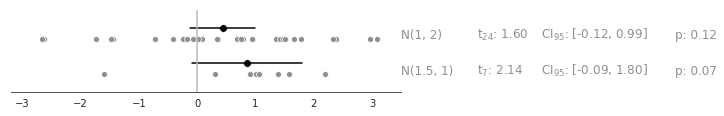

In [90]:
fig = plt.figure(figsize=(7,1.5))
ax = fig.add_subplot(111)
ax.tick_params(top='off', bottom='off',  right='off', left='off', labelleft='off', labelbottom='on')
sns.despine(top=True, bottom=False, left=True)


def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scp.stats.sem(a)
    h = se * scp.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h


np.random.seed(0)
mean_small, lo_small, hi_small = mean_confidence_interval(small_size)
mean_noise, lo_noise, hi_noise = mean_confidence_interval(noisiness)

sns.scatterplot(small_size, [1] * len(small_size), color="#909090")
sns.scatterplot([mean_small], [1.3], color='black', s=60)
ax.plot([lo_small, hi_small], [1.3, 1.3], color='black')

sns.scatterplot(noisiness, [2] * len(noisiness), color="#909090")
sns.scatterplot([mean_noise], [2.3], color='black', s=60)
ax.plot([lo_noise, hi_noise], [2.3, 2.3], color='black')


ax.plot([0, 0], [0, 4], color="#bbbbbb")

ax.set_ylim([0.5, 2.8])
ax.set_xlim([-3.2,3.5])

plt.text(5-1.5, 1, "N(1.5, 1)", color="#909090", fontsize=12)
plt.text(6.3-1.5, 1, "t$_{7}$: " + "{:.2f}".format(t_small), color="#909090", fontsize=12)
plt.text(7.4-1.5, 1, "CI$_{95}$: " + "[{:.2f}, {:.2f}]".format(lo_small, hi_small), color="#909090", fontsize=12)
plt.text(9.7-1.5, 1, "p: " + "{:.2f}".format(p_small), color="#909090", fontsize=12)


plt.text(5-1.5, 2, "N(1, 2)", color="#909090", fontsize=12)
plt.text(6.3-1.5, 2, "t$_{24}$: " + "{:.2f}".format(t_noise), color="#909090", fontsize=12)
plt.text(7.4-1.5, 2, "CI$_{95}$: " + "[{:.2f}, {:.2f}]".format(lo_noise, hi_noise), color="#909090", fontsize=12)
plt.text(9.7-1.5, 2, "p: " + "{:.2f}".format(p_noise), color="#909090", fontsize=12)


plt.savefig('../web/figs/IX-p.svg', dpi=300, bbox_inches='tight', transparent=True)

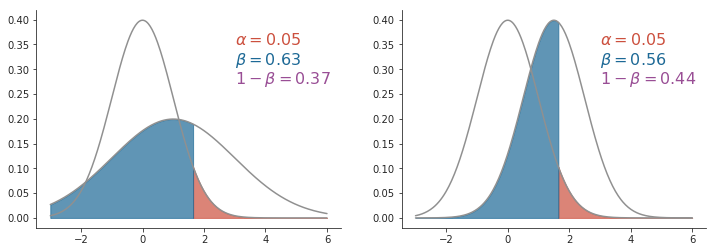

In [133]:
fig = plt.figure(figsize=(12,4))
ax1, ax2 = fig.add_subplot(121), fig.add_subplot(122)
x = np.linspace(-3, 6, 300)
ax1.plot(x, scp.stats.norm(0, 1).pdf(x), c="#909090")
ax1.plot(x, scp.stats.norm(1, 2).pdf(x), c="#909090")

a_005 = scp.stats.norm(0, 1).ppf(0.95)
x_right = np.linspace(a_005, 6, 300)
x_left = np.linspace(-3, a_005, 300)

ax1.fill_between(x_right, scp.stats.norm(0, 1).pdf(x_right), 0, color=color_A, alpha=0.7)
ax1.fill_between(x_left, scp.stats.norm(1, 2).pdf(x_left), 0, color=color_B, alpha=0.7)

ax1.text(3, 0.35, "$\\alpha = 0.05$", color=color_A, size=16)
ax1.text(3, 0.31, "$\\beta = $" + "{:.2f}".format(scp.stats.norm(1, 2).cdf(a_005)), color=color_B, size=16)
ax1.text(3, 0.27, "$1 - \\beta = $" + "{:.2f}".format(1 - scp.stats.norm(1, 2).cdf(a_005)), color="#994e95", size=16)


scp.stats.norm(0, 1).ppf(0.95)

ax2.plot(x, scp.stats.norm(0, 1).pdf(x), c="#909090")
ax2.plot(x, scp.stats.norm(1.5, 1).pdf(x), c="#909090")

ax2.fill_between(x_right, scp.stats.norm(0, 1).pdf(x_right), 0, color=color_A, alpha=0.7)
ax2.fill_between(x_left, scp.stats.norm(1.5, 1).pdf(x_left), 0, color=color_B, alpha=0.7)

ax2.text(3, 0.35, "$\\alpha = 0.05$", color=color_A, size=16)
ax2.text(3, 0.31, "$\\beta = $" + "{:.2f}".format(scp.stats.norm(1.5, 1).cdf(a_005)), color=color_B, size=16)
ax2.text(3, 0.27, "$1 - \\beta = $" + "{:.2f}".format(1 - scp.stats.norm(1.5, 1).cdf(a_005)), color="#994e95", size=16)

sns.despine()
plt.savefig('../web/figs/IX-p-dists.svg', dpi=300, bbox_inches='tight', transparent=True)

In [124]:
scp.stats.norm(1, 2).cdf(a_005)

0.6264353131385674